In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas_datareader as pdr

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import yfinance as yf
from tqdm.autonotebook import tqdm
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Создаем функцию для получение данных о котировках криптокоинов

In [4]:
def get_info(ticker_obj):
    info_keys = ['shortName']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

Скачиваем данные

In [21]:
interesting_tickers = ['BTC-USD','ETH-USD', 'BNB-USD', 'ADA-USD', 'DOGE-USD', 'SHIB-USD', 'LTC-USD', 'ETC-USD', 
           'BCH-USD', 'VET-USD', 'FIL-USD', 'SNX-USD', 'KAVA-USD', 'TWT-USD', 'KSM-USD', 'YFI-USD',
          'UTK-USD', 'RPL-USD', 'SOL-USD', '1INCH-USD', 'THETA-USD', 'OCEAN-USD', 'CHR-USD', 'WRX-USD',
          'DENT-USD', 'DNT-USD', 'CRV-USD', 'DOT-USD', 'KEY-USD', 'BEAM-USD', 'MATIC-USD', 'HEX-USD',
           'AAVE-USD', 'EGLD-USD', 'BTT-USD', 'CAKE-USD', 'HNT-USD', 'DASH-USD', 'ZIL-USD','XDC-USD',
           'KSM-USD','CEL-USD', 'QTUM-USD', 'GLM-USD', 'WAXP-USD', 'NFLX-USD', 'QNT-USD', 'AAPL-USD',
          'NVDA-USD', 'GOOGL-USD']
load = False

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):  #tqdm - помогает понять, сколько уже сделано (визуальная стркоа загрузки)
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1y', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    full_ticker_df_0 = pd.DataFrame(full_ticker_data)
    full_ticker_df = pd.DataFrame(full_ticker_df_0.iloc[:,1:].pct_change(axis='columns'))
    full_ticker_df.insert(0, "shortName", full_ticker_df_0.shortName)
    full_ticker_df.to_csv("C:/ЦМФ/Project-1. Algo-belikova-zvegincev/full_ticker_df_month_01_2022.csv")

else: 
    full_ticker_df = pd.read_csv("C:/ЦМФ/Project-1. Algo-belikova-zvegincev/full_ticker_df_month_01_2022.csv", index_col=0)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

Смотрим на наши данные(общая структура и размерность), проверяем пропущенные значение

In [22]:
#full_ticker_df.isnull().sum(axis=1)
full_ticker_df.shape

(50, 367)

In [32]:
#full_ticker_df.drop('2021-10-06 00:00:00', axis=1, inplace=True)
full_ticker_df

,shortName,2021-10-07 00:00:00,2021-10-08 00:00:00,2021-10-09 00:00:00,2021-10-10 00:00:00,2021-10-11 00:00:00,2021-10-12 00:00:00,2021-10-13 00:00:00,2021-10-14 00:00:00,2021-10-15 00:00:00,...,2022-09-26 00:00:00,2022-09-27 00:00:00,2022-09-28 00:00:00,2022-09-29 00:00:00,2022-09-30 00:00:00,2022-10-01 00:00:00,2022-10-02 00:00:00,2022-10-03 00:00:00,2022-10-04 00:00:00,2022-10-05 00:00:00
0,Bitcoin USD,-0.028097,0.003008,0.018536,-0.003577,0.049537,-0.025115,0.024269,-0.001386,0.074534,...,0.022368,-0.005833,0.016544,0.007532,-0.007217,-0.006160,-0.013877,0.030428,0.036347,-0.008660
1,Ethereum USD,0.002070,-0.006749,0.003355,-0.041912,0.034882,-0.014887,0.032534,0.049862,0.020238,...,0.031759,-0.003889,0.005476,-0.001315,-0.005745,-0.012300,-0.027104,0.037102,0.029232,-0.006820
2,BNB USD,0.007718,-0.044807,0.005840,-0.039094,0.020705,0.073554,0.060564,0.002704,0.003560,...,0.006811,-0.012780,0.034433,0.007125,0.001421,-0.004646,0.005519,0.009137,0.032284,-0.007293
3,Cardano USD,0.029311,-0.017488,0.013159,-0.030619,-0.010843,-0.024938,0.032967,-0.008538,0.020406,...,0.001275,-0.010894,-0.010410,0.002012,-0.008572,-0.009486,-0.024774,0.019934,0.018147,-0.010308
4,Dogecoin USD,-0.047861,0.003820,0.011257,-0.068091,0.007389,-0.022725,0.027979,-0.001286,0.006497,...,-0.001030,-0.007857,0.000231,0.001732,0.015232,-0.016642,-0.022086,0.018486,0.092375,-0.018602
5,Shiba Inu USD,-0.178571,0.173913,0.000000,-0.037037,0.192308,-0.064516,0.000000,-0.068966,-0.074074,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,-0.083333
6,Litecoin USD,0.000370,-0.015659,0.020948,-0.024157,0.023429,-0.036942,0.027955,0.014018,0.048278,...,0.015201,-0.013004,0.010830,0.011361,-0.009590,-0.009180,-0.018811,0.043624,0.020715,-0.013005
7,Ethereum Classic USD,-0.010732,-0.011858,0.035923,-0.045873,0.018449,-0.022969,0.011557,0.019633,-0.002093,...,0.004158,-0.010527,-0.016841,0.004982,-0.002951,-0.006455,-0.022395,0.019876,0.017330,-0.011164
8,Bitcoin Cash USD,-0.010641,-0.026765,0.031406,-0.045308,0.025856,-0.023864,0.012016,0.005228,0.044990,...,0.023811,-0.015450,-0.001267,0.021686,0.028269,-0.023801,-0.023717,0.016225,0.042882,0.008027
9,VeChain USD,-0.005636,-0.001468,0.059627,-0.061434,-0.014714,-0.022702,0.080606,0.030465,0.006315,...,0.012577,-0.002290,0.010463,0.025384,-0.017470,0.011839,-0.031673,0.042358,0.017367,-0.003089


## Заполняем данные по ценам за последнюю дату (сейчас NA - Так как данных за текущий день еще нет)

In [30]:
full_ticker_df = full_ticker_df.iloc[:, :-1]
prices = full_ticker_df.iloc[:, 5:].T
prices = prices.fillna(method='backfill')
prices = prices.fillna(method='ffill')
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T)

In [31]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].T).T

# KMeans

  0%|          | 0/28 [00:00<?, ?it/s]

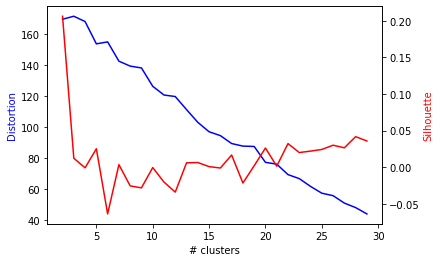

In [33]:
distortions = []
silhouette = []
K = range(2,30)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="euclidean"))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()  #Правило локтя - помогает определить какое кол-во кластеров нужно и возможно сделать.

#  Используем информацию о количсетве кластеров с помощью силуэта (так как он дает более точный ответ на вопрос о кол-ве класторов по сравнению с правилом локтя)

In [34]:
n_clusters = 4
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_clusters=4, n_jobs=6)

Делаем визуализацию распределения кластеров

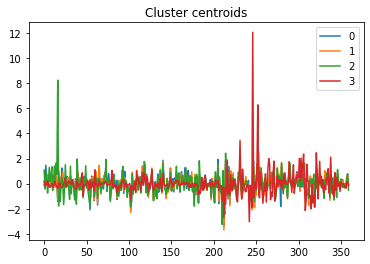

In [35]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [36]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

Определяем для клаждего токена его кластер

In [37]:
full_ticker_df['cluster'] = ts_kmeans.predict(tickers_scaled)

Смотрим на наше распределение (как отработал базовый kMeans)

                          Cluster number: 0


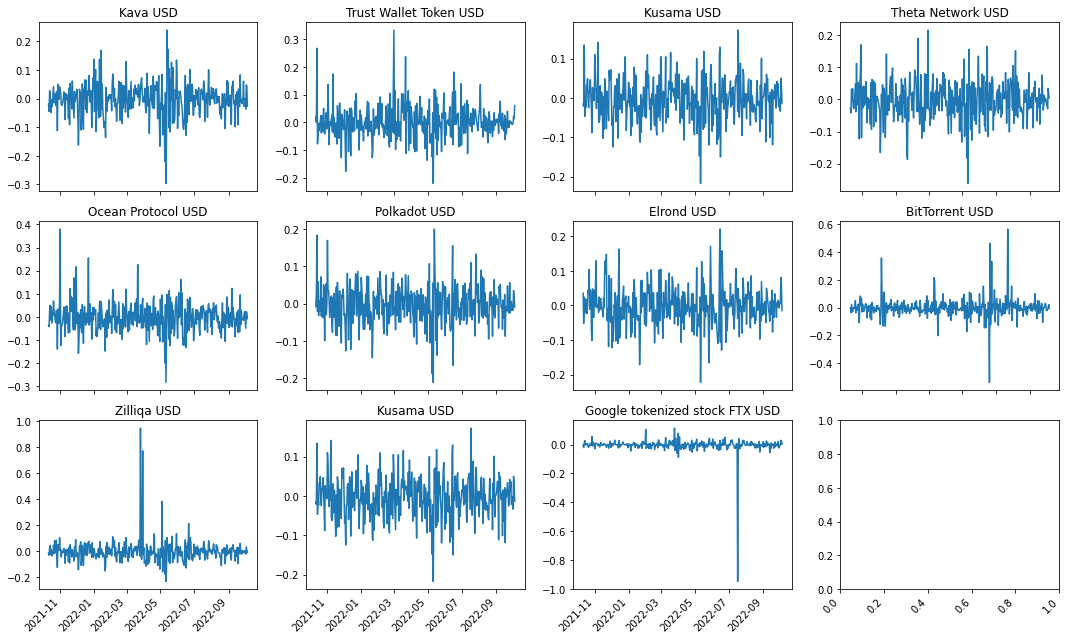

                          Cluster number: 1


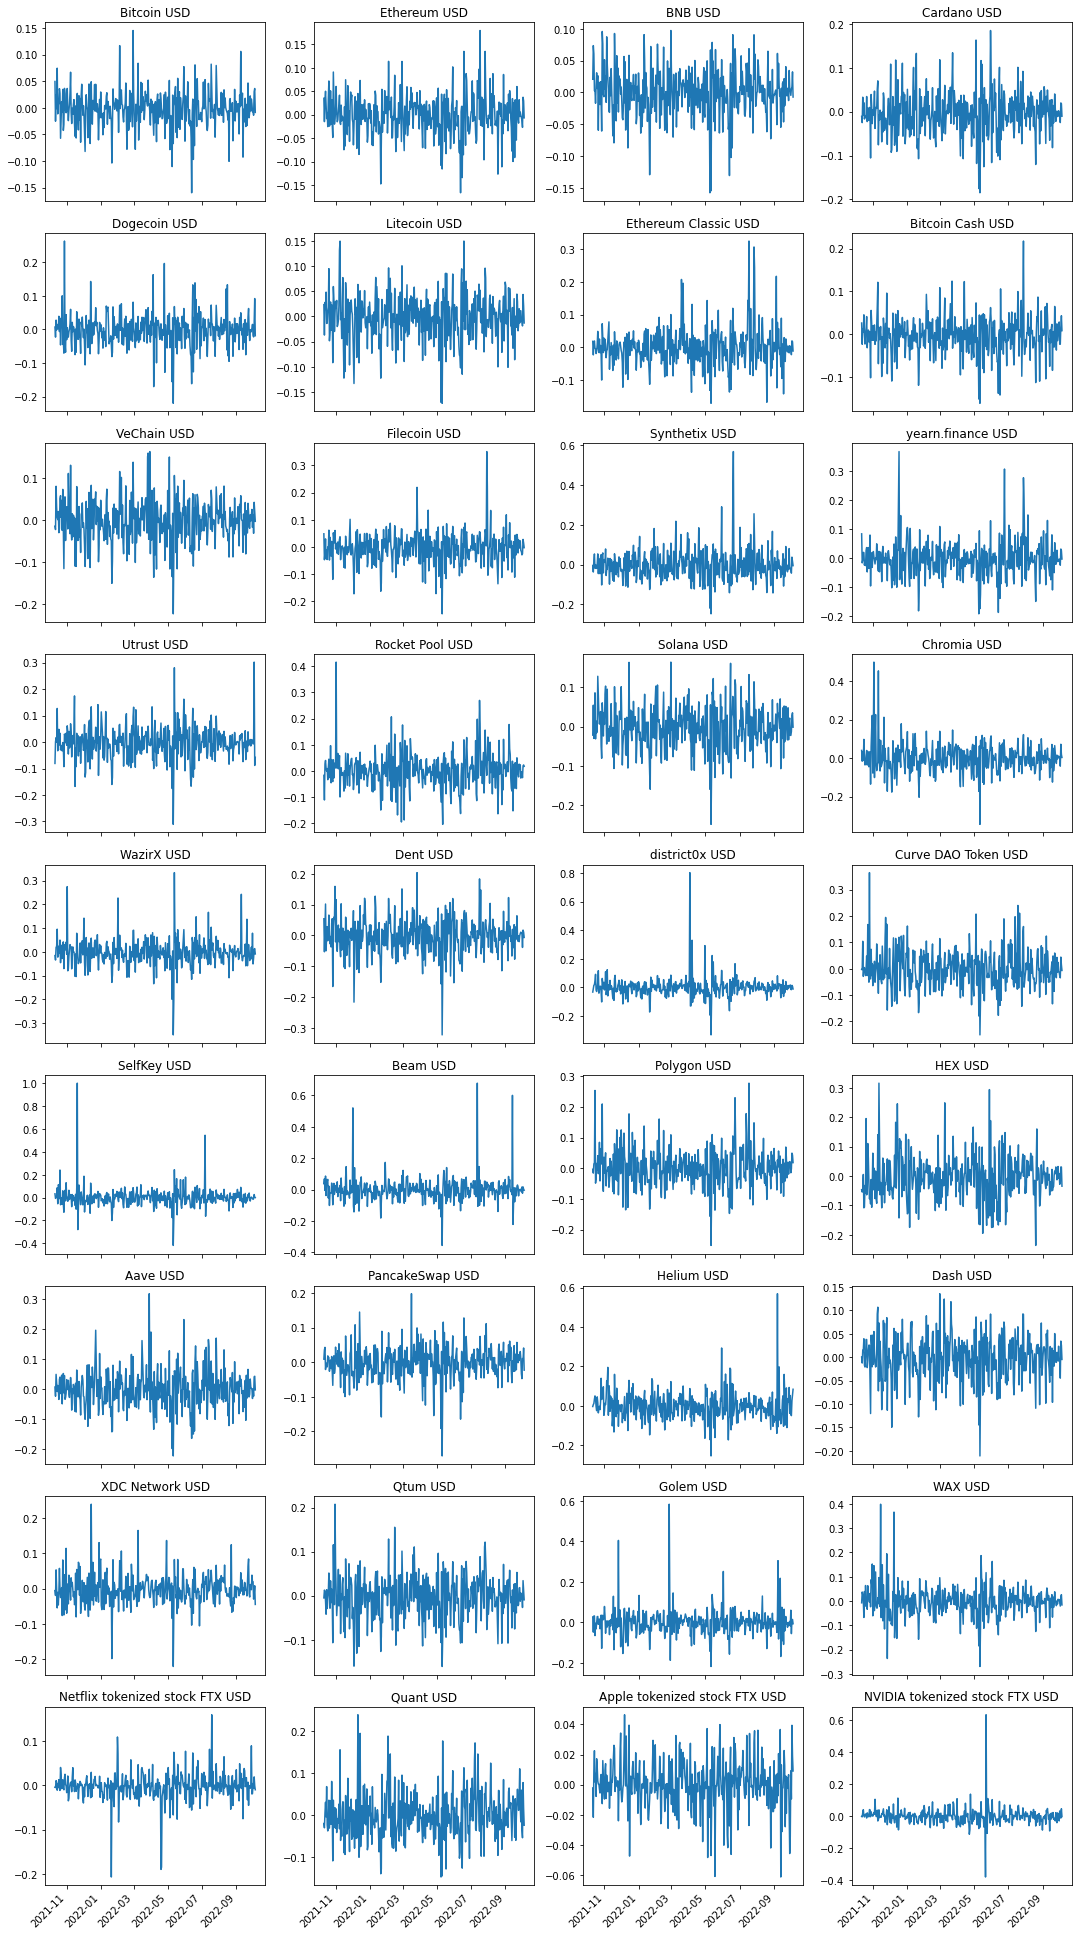

                          Cluster number: 2


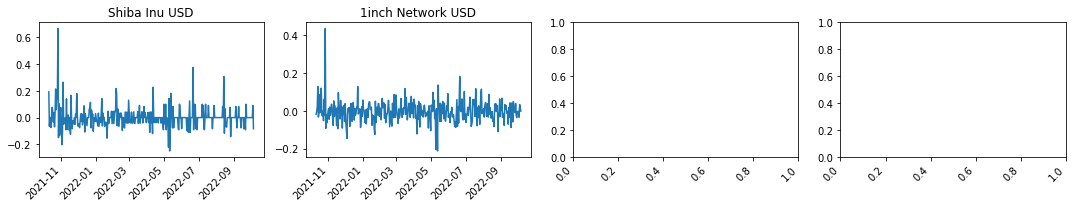

                          Cluster number: 3


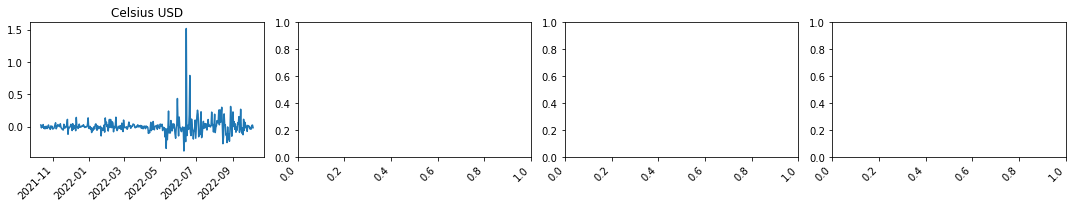

In [38]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

# Иерархическая кластеризация

Берем уже скаченную нами базу данных и используем метод linkage с метриками евклидового расстояния, чтобы распределить наши тикеры по кластерам (использую Иераррхическую кластеризацию)

In [39]:
full_ticker_df_2 = full_ticker_df
link = linkage(full_ticker_df_2.iloc[:,2:], 'ward', 'euclidean')

Рисуем дендограмму, которая будет отражать, какое кол-во кластеров нам необходимо взять

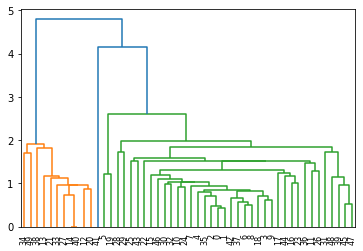

In [40]:
dn = dendrogram(link, orientation='top')
full_ticker_df_2['cluster'] = fcluster(link, 2, criterion='maxclust')

In [41]:
full_ticker_df_2.head()

,shortName,2021-10-07 00:00:00,2021-10-08 00:00:00,2021-10-09 00:00:00,2021-10-10 00:00:00,2021-10-11 00:00:00,2021-10-12 00:00:00,2021-10-13 00:00:00,2021-10-14 00:00:00,2021-10-15 00:00:00,...,2022-09-27 00:00:00,2022-09-28 00:00:00,2022-09-29 00:00:00,2022-09-30 00:00:00,2022-10-01 00:00:00,2022-10-02 00:00:00,2022-10-03 00:00:00,2022-10-04 00:00:00,2022-10-05 00:00:00,cluster
0,Bitcoin USD,-0.028097,0.003008,0.018536,-0.003577,0.049537,-0.025115,0.024269,-0.001386,0.074534,...,-0.005833,0.016544,0.007532,-0.007217,-0.006160,-0.013877,0.030428,0.036347,-0.008660,2
1,Ethereum USD,0.002070,-0.006749,0.003355,-0.041912,0.034882,-0.014887,0.032534,0.049862,0.020238,...,-0.003889,0.005476,-0.001315,-0.005745,-0.012300,-0.027104,0.037102,0.029232,-0.006820,2
2,BNB USD,0.007718,-0.044807,0.005840,-0.039094,0.020705,0.073554,0.060564,0.002704,0.003560,...,-0.012780,0.034433,0.007125,0.001421,-0.004646,0.005519,0.009137,0.032284,-0.007293,2
3,Cardano USD,0.029311,-0.017488,0.013159,-0.030619,-0.010843,-0.024938,0.032967,-0.008538,0.020406,...,-0.010894,-0.010410,0.002012,-0.008572,-0.009486,-0.024774,0.019934,0.018147,-0.010308,2
4,Dogecoin USD,-0.047861,0.003820,0.011257,-0.068091,0.007389,-0.022725,0.027979,-0.001286,0.006497,...,-0.007857,0.000231,0.001732,0.015232,-0.016642,-0.022086,0.018486,0.092375,-0.018602,2


Визуализируем наше рапсредление активов по кластерам и смотрим на качество отрабокти алгоритма Иерархической кластеризации

                          Cluster number: 1


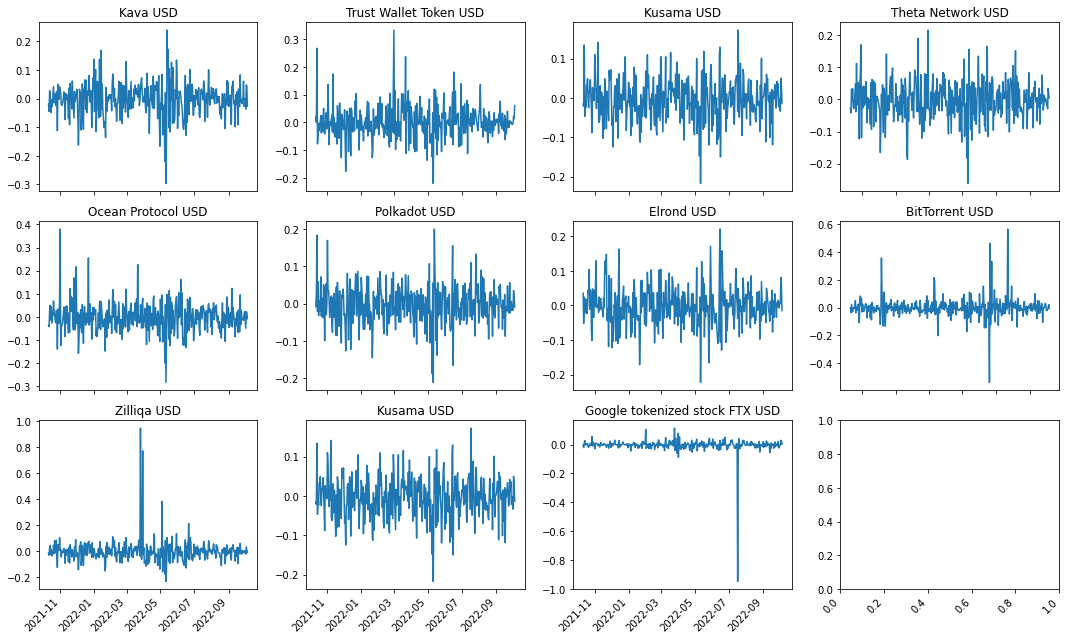

                          Cluster number: 2


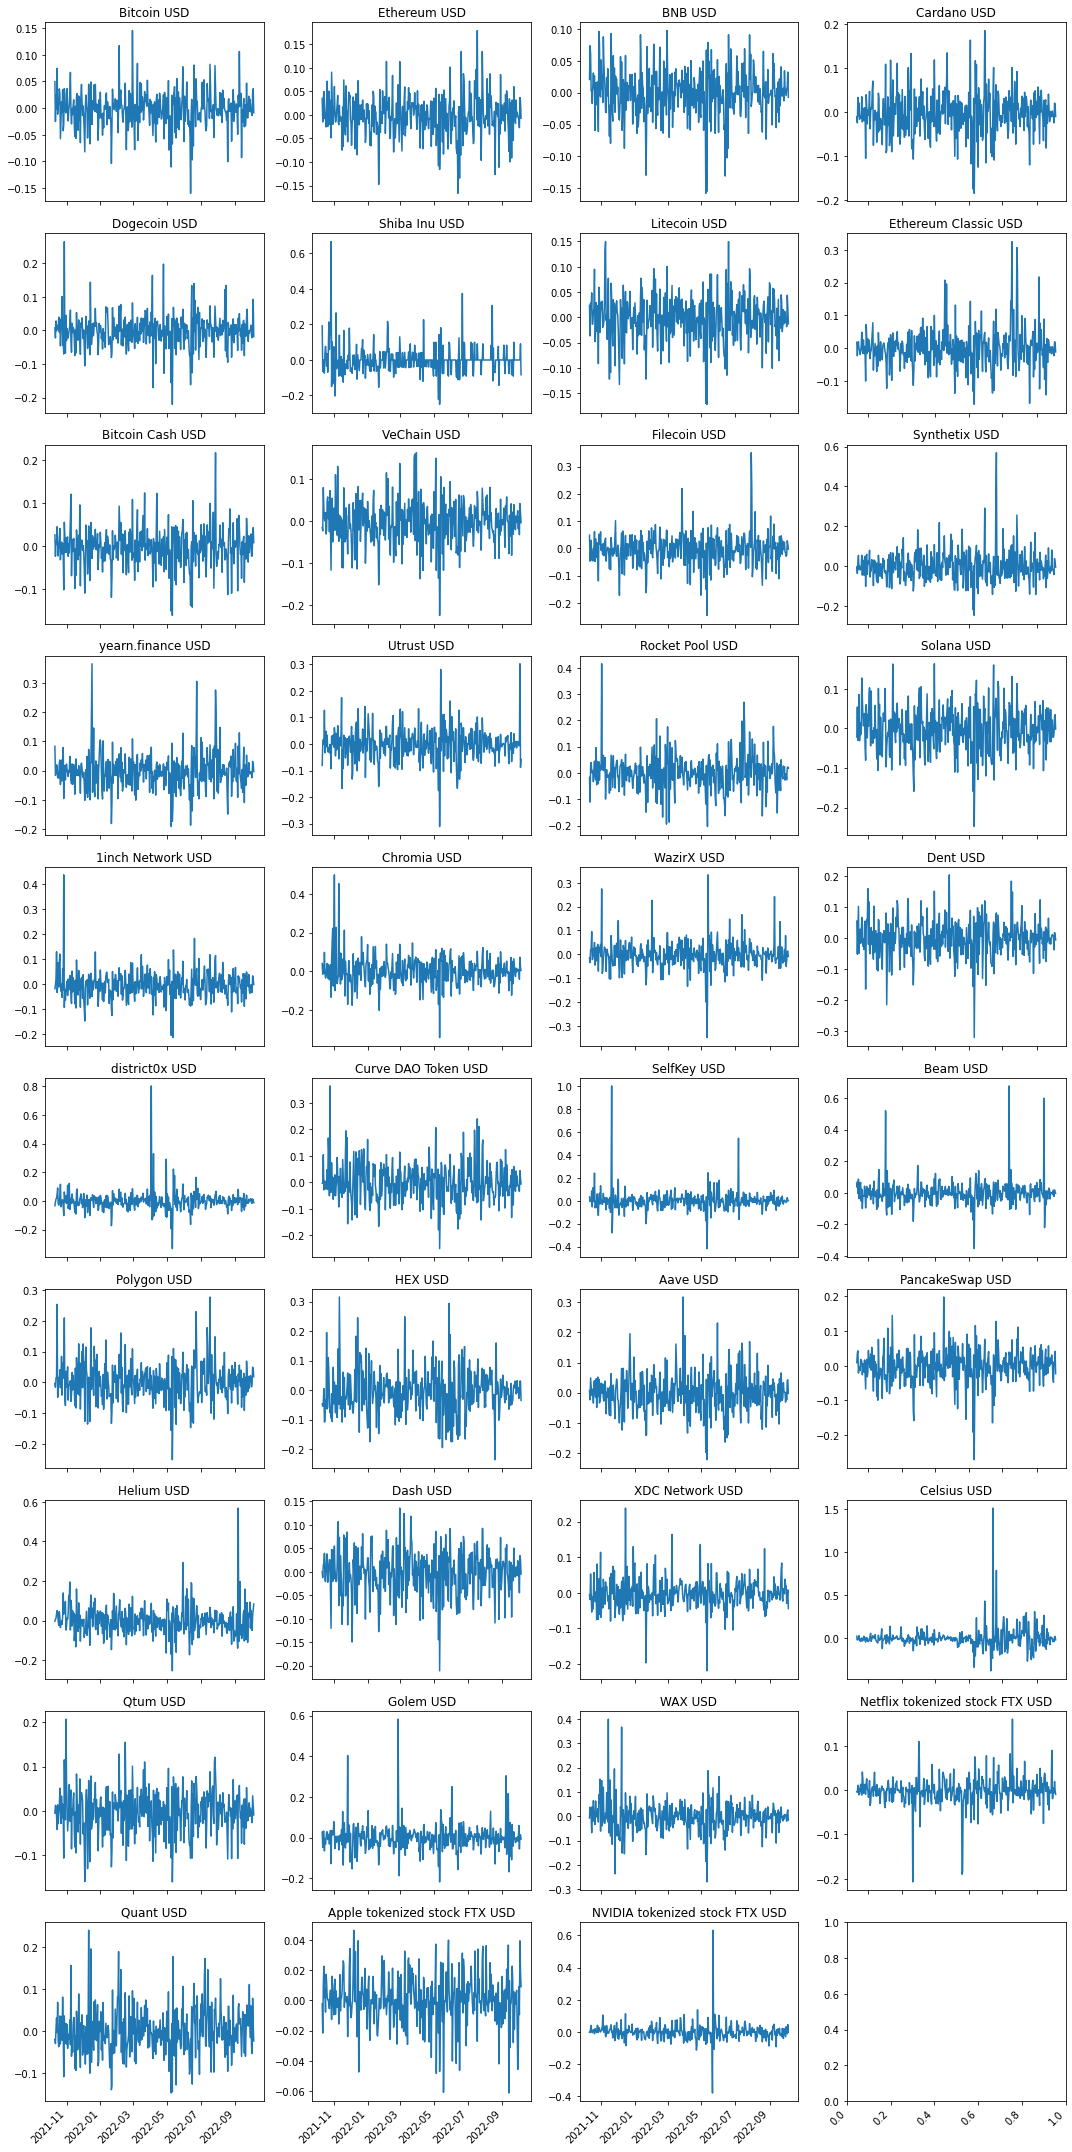

In [42]:
n_clusters_2 = 2
for cluster in range(1,n_clusters_2+1):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df_2[full_ticker_df_2.cluster==cluster])